# Homework 02 - Implementing and Training an MLP

### 1. Packages

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

### 2. MNIST classification


#### 2.1. Loading the MNIST dataset

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

tfds.show_examples(ds_train, ds_info)

* **How many training/test images are there?**
For training 60,000 and for testing 10,000; a total of 70,000.

* **What's the image shape?**
Square images of 28x28 pixels.

* **What range are pixel values in?**
The colors of the pixels are black or white, meaning that their value is of 0 or 255 respectively.

#### 2.2. Setting up the data pipeline

In [ ]:
def prepare_data(mnist):
    # flatten images into vectors
    mnist = mnist.map(lambda img, target: (tf.reshape(img, (-1,)), target), num_parallel_calls=tf.data.AUTOTUNE)
    # normalize images from uint8 -> float32
    mnist = mnist.map(lambda img, target: (tf.cast(img, tf.float32), target), num_parallel_calls=tf.data.AUTOTUNE)
    # normalize inputs from 0-255 to [-1, 1]
    mnist = mnist.map(lambda img, target: ((img/128.)-1., target), num_parallel_calls=tf.data.AUTOTUNE)
    # create one-hot targets
    mnist = mnist.map(lambda img, target: (img, tf.one_hot(target, depth=10)), num_parallel_calls=tf.data.AUTOTUNE)
    # cache in memory
    mnist = mnist.cache()
    # mnist = mnist.shuffle(1000)
    mnist = mnist.shuffle(ds_info.splits['train'].num_examples)
    mnist = mnist.batch(32)
    # mnist = mnist.prefetch(20)
    mnist = mnist.prefetch(tf.data.AUTOTUNE)
    return mnist

ds_train = ds_train.apply(prepare_data)
ds_test = ds_test.apply(prepare_data)

# ### alternative solution ###
# def normalize_img(image, label):
#     """Normalizes images: uint8 -> float32"""
#     return tf.cast(image, tf.float32) / 255., label

# # data/training pipeline
# ds_train = ds_train.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
# ds_train = ds_train.cache()
# ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
# ds_train = ds_train.batch(128)
# ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

# # evaluation pipeline
# ds_test = ds_test.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
# ds_test = ds_test.batch(128)
# ds_test = ds_test.cache()
# ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

#### 2.3. Building a deep neural network with TensorFlow

In [ ]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.dense1 = tf.keras.layers.Dense(256, activation='relu')
        self.dense2 = tf.keras.layers.Dense(256, activation='relu')
        self.out = tf.keras.layers.Dense(10, activation='softmax')

    @tf.function
    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.out(x)
        return x

### alternative solution ###
# basically the same, only less customizable
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Flatten(input_shape=(28, 28)),
#     # tf.keras.layers.Dense(256, activation='relu', name='dense1'),
#     tf.keras.layers.Dense(128, activation='relu', name='dense2'),
#     tf.keras.layers.Dense(10, name='out')
# ])

#### 2.4. Training the network

In [ ]:
def train_step(model, input, target, loss_function, accuracy_function, optimizer):
    with tf.GradientTape() as tape:
        prediction = model(input)
        loss = loss_function(target, prediction)
        accuracy = accuracy_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, accuracy

def test(mode, test_data, loss_function):
    test_accuracy_aggregator = []
    test_loss_aggregator = []

    for (input, target) in test_data:
        prediction = model(input)
        sample_test_loss = loss_function(target, prediction)
        sample_test_accuracy = np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
        sample_test_accuracy = np.mean(sample_test_accuracy)
        test_loss_aggregator.append(sample_test_loss.numpy())
        test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

    test_loss = tf.reduce_mean(test_loss_aggregator)
    test_accuracy = tf.reduce_mean(test_accuracy_aggregator)

    return test_loss, test_accuracy

In [ ]:
tf.keras.backend.clear_session()

### hyperparams
num_epochs = 10
learning_rate = 0.2

model = MyModel()

cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
accuracy_metrics = tf.keras.metrics.Accuracy()
optimizer = tf.keras.optimizers.SGD(learning_rate)
# optimizer = tf.keras.optimizers.Adam(learning_rate)

train_losses = []
train_accuracies = []

test_losses = []
test_accuracies = []

test_loss, test_accuracy = test(model, ds_test, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

# check model performance on training data
train_loss, train_acc = test(model, ds_train, cross_entropy_loss)
train_losses.append(train_loss)
# print(train_loss)
# print(train_acc)
train_accuracies.append(train_acc)

for epoch in range(num_epochs):
    print(f'Epoch: {str(epoch)} starting with accuracy {test_accuracies[-1]}')

    epoch_loss_agg = []
    epoch_acc_agg = []
    for input, target in ds_train:
        # print(str(optimizer))
        train_loss, train_acc = train_step(model, input, target, cross_entropy_loss, accuracy_metrics, optimizer)
        epoch_loss_agg.append(train_loss)
        epoch_acc_agg.append(train_acc)

    # track training loss
    train_losses.append(tf.reduce_mean(epoch_loss_agg)) # TODO: this is causing issues
    train_accuracies.append(tf.reduce_mean(epoch_acc_agg))
    # print("Train accuracy in epoch: ", train_accuracies[0])

    # testing to enable accuracy and test loss tracking
    test_loss, test_accuracy = test(model, ds_test, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

# ### alternative solution ###
# model.compile(
#     # optimizer=tf.keras.optimizers.SGD(learning_rate),
#     optimizer=tf.keras.optimizers.Adam(learning_rate),
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#     metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
# )

# print("Fit model on training data")
# model.fit(
#     ds_train,
#     epochs=num_epochs,
#     validation_data=ds_test,
# )

# results = model.evaluate(ds_train, batch_size=128)

#### 2.5. Visualization

In [ ]:
def visualization(train_losses, train_accuracies, test_losses, test_accuracies):
    """
    Visualizes accuracy and loss for training and test data using
    the mean of each epoch.
    Loss is displayed in a regular line, accuracy in a dotted line.
    Training data is displayed in blue, test data in red.

    Parameters
    ----------
    train_losses: numpy.ndarray
    training losses
    train_accuracies: numpy.ndarray
    training accuracies
    test_losses: numpy.ndarray
    test losses
    test_accuracies: numpy.ndarray
    test accuracies
    """

    plt.figure ()
    line1, = plt.plot (train_losses, "b-")
    line2, = plt.plot (test_losses, "r-")
    line3, = plt.plot (train_accuracies, "b:")
    line4, = plt.plot (test_accuracies, "r:")
    plt.xlabel ("Training steps")
    plt.ylabel ("Loss / Accuracy")
    plt.legend ((line1, line2, line3, line4), ("training loss", "test loss", "train accuracy", "test accuracy"))
    plt.show()

visualization(train_losses, train_accuracies, test_losses, test_accuracies)

### 3. Adjusting the hyperparameters of your model

1. Obervation: Learning Rate reduction/increase.
The more we increase the Learning Rate, the higher is maximised the loss, and the less accurate the results become. With a reduced Learning rate, the test accuracy increases, and the loss is reduced. (CategoricalCrossentropy loss function, 10 epochs)

Learning Rate = 0.2

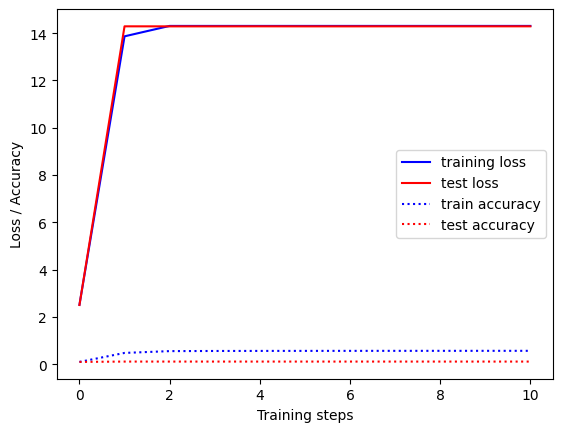

Learning Rate = 0.0002
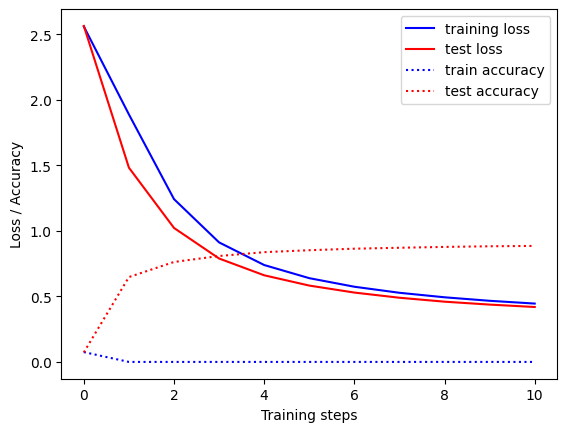

2. Observation: Mean Absolute Error Loss function instead of the CategoricalCrossentropy loss function.
The loss is reduced to 0.1, while the test accuracy nears to 0.7. (Learning rate: 0.1)
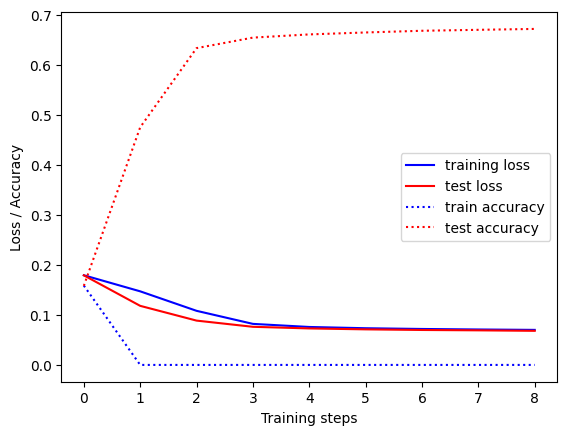


3. Observation: Epoch changes.
Having very few epochs (3-4) doesn't change the result much compared to a high number of epochs (>10), as the model converges fairly quickly with these settings (learning rate: 0.01).

4. Observation: Optimizer choice.
The SGD optimization performs better than Adam. It converges faster, requires less compute power and runtime (in this task at least). This is likely due to the fact that Adam is [known to perform worse](https://opt-ml.org/papers/2021/paper53.pdf) on image classification tasks.